# Working with Images & Logistic Regression in PyTorch

In [2]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST

In [3]:
# Download the training Dataset
dataset = MNIST(root='data/', download = True)

When this statement is executed for the first time, it downloads the data to the data/ directory next to the notebook and creates a PyTorch Dataset. On subsequent executions, the download is skipped as the data is already downloaded. Let's check the size of the dataset.

In [4]:
len(dataset)

60000

The dataset has 60,000 images that we'll use to train the model. There is also an additional test set of 10,000 images used for evaluating models and reporting metrics in papers and reports. We can create the test dataset using the MNIST class by passing train=False to the constructor.

In [5]:
test_dataset = MNIST(root = 'data/', train = False)
len(test_dataset)

10000

In [6]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x20AAF730880>, 5)

It's a pair, consisting of a 28x28px image and a label. The image is an object of the class PIL.Image.Image, which is a part of the Python imaging library Pillow. We can view the image within Jupyter using matplotlib, the de-facto plotting and graphing library for data science in Python.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

The statement %matplotlib inline indicates to Jupyter that we want to plot the graphs within the notebook. Without this line, Jupyter will show the image in a popup. Statements starting with % are called magic commands and are used to configure the behavior of Jupyter itself. You can find a full list of magic commands here: https://ipython.readthedocs.io/en/stable/interactive/magics.html .

Let's look at a couple of images from the dataset.

Label: 5


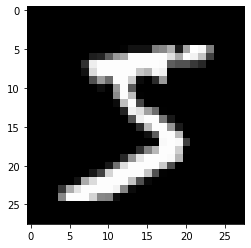

In [8]:
image, label = dataset[0]
plt.imshow(image, cmap = 'gray')
print('Label:', label)

Label: 3


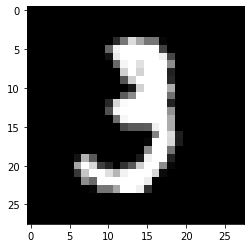

In [9]:
image, label = dataset[10]
plt.imshow(image, cmap = 'gray')
print('Label:', label)

It's evident that these images are relatively small in size, and recognizing the digits can sometimes be challenging even for the human eye. While it's useful to look at these images, there's just one problem here: PyTorch doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

In [10]:
import torchvision.transforms as transforms

PyTorch datasets allow us to specify one or more transformation functions that are applied to the images as they are loaded. The torchvision.transforms module contains many such predefined functions. We'll use the ToTensor transform to convert images into PyTorch tensors.

In [11]:
# MNINST dataset (images and labels)
dataset = MNIST(root = 'data/',
                train = True,
                transform = transforms.ToTensor())

In [12]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


The image is now converted to a 1x28x28 tensor. The first dimension tracks color channels. The second and third dimensions represent pixels along the height and width of the image, respectively. Since images in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are three channels: red, green, and blue (RGB).

Let's look at some sample values inside the tensor.

In [13]:
print(img_tensor[0, 10:15, 10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


The values range from 0 to 1, with 0 representing black, 1 white, and the values in between different shades of grey. We can also plot the tensor as an image using plt.imshow.

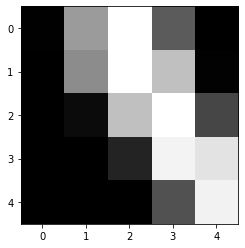

In [14]:
# Plot the image by passing in the 28x28 matrix
plt.imshow(img_tensor[0, 10:15, 10:15], cmap = 'gray')

Note that we need to pass just the 28x28 matrix to plt.imshow, without a channel dimension. We also pass a color map (cmap=gray) to indicate that we want to see a grayscale image.

## Training and Validation Datasets

While building real-world machine learning models, it is quite common to split the dataset into three parts:

- Training set - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.

- Validation set - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.

- Test set - used to compare different models or approaches and report the model's final accuracy.

In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images.

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the random_spilt method from PyTorch.

In [15]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

It's essential to choose a random sample for creating a validation set. Training data is often sorted by the target labels, i.e., images of 0s, followed by 1s, followed by 2s, etc. If we create a validation set using the last 20% of images, it would only consist of 8s and 9s. In contrast, the training set would contain no 8s or 9s. Such a training-validation would make it impossible to train a useful model.

We can now create data loaders to help us load the data in batches. We'll use a batch size of 128.

In [16]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle = True)
val_loader = DataLoader(val_ds, batch_size)

We set shuffle=True for the training data loader to ensure that the batches generated in each epoch are different. This randomization helps generalize & speed up the training process. On the other hand, since the validation data loader is used only for evaluating the model, there is no need to shuffle the images.

## Model

Now that we have prepared our data loaders, we can define our model.

 - A logistic regression model is almost identical to a linear regression model. It contains weights and bias matrices, and the output is obtained using simple matrix operations (pred = x @ w.t() + b).

 - As we did with linear regression, we can use nn.Linear to create the model instead of manually creating and initializing the matrices.

 - Since nn.Linear expects each training example to be a vector, each 1x28x28 image tensor is flattened into a vector of size 784 (28*28) before being passed into the model.

 - The output for each image is a vector of size 10, with each element signifying the probability of a particular target label (i.e., 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [17]:
import torch.nn as nn

input_size = 28*28
num_classes = 10

# Logistic Regression Model
model = nn.Linear(input_size, num_classes)

Of course, this model is a lot larger than our previous model in terms of the number of parameters. Let's take a look at the weights and biases.

In [18]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-0.0036,  0.0132, -0.0059,  ...,  0.0180, -0.0191,  0.0214],
        [-0.0099,  0.0041, -0.0149,  ...,  0.0166, -0.0163,  0.0212],
        [ 0.0135,  0.0137, -0.0312,  ..., -0.0159, -0.0095, -0.0279],
        ...,
        [-0.0090,  0.0302, -0.0061,  ...,  0.0265, -0.0261, -0.0251],
        [ 0.0088,  0.0102,  0.0145,  ..., -0.0059,  0.0006, -0.0138],
        [-0.0354,  0.0074,  0.0116,  ...,  0.0080, -0.0026,  0.0034]],
       requires_grad=True)

In [19]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([ 0.0068,  0.0252, -0.0267, -0.0342,  0.0286,  0.0241,  0.0018,  0.0301,
         0.0076,  0.0165], requires_grad=True)

Although there are a total of 7850 parameters here, conceptually, nothing has changed so far. Let's try and generate some outputs using our model. We'll take the first batch of 100 images from our dataset and pass them into our model.

In [20]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    print(outputs)
    break

tensor([6, 3, 0, 0, 1, 2, 1, 2, 4, 2, 4, 7, 6, 9, 6, 3, 5, 0, 1, 4, 4, 9, 3, 1,
        5, 3, 1, 0, 7, 6, 1, 2, 8, 7, 2, 2, 2, 5, 4, 6, 9, 5, 4, 6, 1, 2, 1, 9,
        3, 2, 8, 2, 6, 7, 6, 4, 2, 7, 7, 9, 2, 7, 0, 8, 1, 8, 3, 0, 1, 3, 6, 0,
        9, 9, 8, 4, 7, 1, 7, 1, 7, 1, 6, 9, 2, 9, 2, 4, 6, 3, 9, 6, 0, 3, 3, 7,
        8, 7, 8, 5, 6, 4, 9, 1, 8, 9, 7, 7, 8, 0, 7, 1, 8, 6, 6, 1, 9, 4, 1, 0,
        8, 8, 4, 0, 0, 0, 7, 3])
torch.Size([128, 1, 28, 28])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3584x28 and 784x10)

In [21]:
images.shape

torch.Size([128, 1, 28, 28])

In [22]:
images.reshape(128, 784).shape

torch.Size([128, 784])

The code above leads to an error because our input data does not have the right shape. Our images are of the shape 1x28x28, but we need them to be vectors of size 784, i.e., we need to flatten them. We'll use the .reshape method of a tensor, which will allow us to efficiently 'view' each image as a flat vector without really creating a copy of the underlying data. To include this additional functionality within our model, we need to define a custom model by extending the nn.Module class from PyTorch.


In [23]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()

Inside the __init__ constructor method, we instantiate the weights and biases using nn.Linear. And inside the forward method, which is invoked when we pass a batch of inputs to the model, we flatten the input tensor and pass it into self.linear.

xb.reshape(-1, 28*28) indicates to PyTorch that we want a view of the xb tensor with two dimensions. The length along the 2nd dimension is 28*28 (i.e., 784). One argument to .reshape can be set to -1 (in this case, the first dimension) to let PyTorch figure it out automatically based on the shape of the original tensor.

Note that the model no longer has .weight and .bias attributes (as they are now inside the .linear attribute), but it does have a .parameters method that returns a list containing the weights and bias.

In [24]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [25]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[ 0.0248,  0.0156,  0.0029,  ...,  0.0241,  0.0103,  0.0270],
         [ 0.0028, -0.0059, -0.0090,  ...,  0.0350,  0.0111,  0.0238],
         [ 0.0098, -0.0208,  0.0334,  ...,  0.0309,  0.0256,  0.0346],
         ...,
         [ 0.0024,  0.0177, -0.0140,  ..., -0.0352,  0.0008,  0.0298],
         [ 0.0138,  0.0053,  0.0143,  ...,  0.0248,  0.0197, -0.0278],
         [-0.0289, -0.0116, -0.0058,  ..., -0.0165,  0.0011,  0.0032]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0262,  0.0147, -0.0341,  0.0101,  0.0237,  0.0302, -0.0077, -0.0071,
         -0.0258,  0.0332], requires_grad=True)]

In [26]:
for images, labels in train_loader:
    print(images.shape)
    outputs = model(images)
    break
    
print('outputs.shape:', outputs.shape)
print('Sample Outputs:', outputs[:2].data)

torch.Size([128, 1, 28, 28])
outputs.shape: torch.Size([128, 10])
Sample Outputs: tensor([[ 0.1810,  0.1097, -0.2153,  0.0450, -0.0177, -0.0113, -0.0605, -0.2969,
          0.1684,  0.0084],
        [ 0.0357,  0.1367, -0.3452,  0.1377, -0.1532,  0.0662, -0.0338, -0.1584,
         -0.0967, -0.0927]])


In [27]:
import torch.nn.functional as F

In [28]:
# Apply Softmax for each row outputs
probs = F.softmax(outputs, dim = 1)

# Look at Sample Probabilites
print('Sample Probabilites:\n', probs[:2].data)

# Add up the probabilities of the output row
print('Sum:', torch.sum(probs[0]))

Sample Probabilites:
 tensor([[0.1197, 0.1114, 0.0805, 0.1045, 0.0981, 0.0987, 0.0940, 0.0742, 0.1182,
         0.1007],
        [0.1079, 0.1194, 0.0737, 0.1195, 0.0893, 0.1112, 0.1007, 0.0889, 0.0945,
         0.0949]])
Sum: tensor(1.0000, grad_fn=<SumBackward0>)


Finally, we can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. We can do this using torch.max, which returns each row's largest element and the corresponding index.

In [29]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([0, 3, 7, 3, 0, 0, 1, 2, 4, 5, 6, 4, 4, 0, 8, 7, 6, 3, 3, 3, 0, 6, 4, 0,
        6, 3, 3, 3, 3, 1, 0, 3, 1, 5, 6, 3, 5, 7, 3, 1, 3, 3, 0, 7, 4, 5, 1, 1,
        0, 6, 4, 3, 1, 4, 0, 7, 9, 4, 3, 6, 3, 0, 6, 3, 6, 0, 4, 3, 6, 6, 8, 1,
        0, 3, 0, 0, 0, 9, 1, 3, 6, 9, 6, 9, 1, 3, 9, 4, 3, 0, 3, 3, 3, 3, 0, 7,
        3, 3, 3, 3, 9, 0, 3, 6, 6, 3, 3, 3, 6, 0, 3, 3, 3, 3, 3, 3, 6, 3, 2, 4,
        6, 4, 1, 3, 4, 1, 3, 7])
tensor([0.1197, 0.1195, 0.1315, 0.1505, 0.1127, 0.1177, 0.1300, 0.1125, 0.1182,
        0.1321, 0.1199, 0.1303, 0.1207, 0.1272, 0.1173, 0.1244, 0.1562, 0.1249,
        0.1220, 0.1335, 0.1269, 0.1330, 0.1208, 0.1130, 0.1502, 0.1360, 0.1113,
        0.1222, 0.1334, 0.1248, 0.1438, 0.1388, 0.1210, 0.1258, 0.1277, 0.1247,
        0.1213, 0.1144, 0.1480, 0.1281, 0.1175, 0.1354, 0.1286, 0.1222, 0.1280,
        0.1129, 0.1393, 0.1242, 0.1230, 0.1414, 0.1221, 0.1355, 0.1230, 0.1235,
        0.1164, 0.1596, 0.1170, 0.1238, 0.1188, 0.1302, 0.1408, 0.1252, 0.1270,
       

In [30]:
labels

tensor([4, 5, 0, 5, 7, 9, 1, 0, 9, 5, 0, 8, 7, 1, 2, 9, 2, 4, 1, 4, 7, 7, 7, 7,
        3, 0, 7, 4, 5, 3, 2, 6, 3, 5, 2, 4, 9, 7, 1, 3, 4, 5, 6, 7, 8, 7, 5, 2,
        9, 8, 3, 2, 5, 4, 3, 6, 6, 5, 3, 2, 5, 8, 0, 0, 0, 9, 3, 9, 1, 9, 4, 4,
        4, 9, 8, 9, 7, 7, 8, 6, 3, 6, 0, 4, 3, 9, 0, 4, 9, 9, 6, 4, 6, 0, 8, 7,
        4, 7, 5, 0, 2, 5, 1, 2, 2, 1, 8, 2, 6, 3, 3, 1, 4, 4, 8, 0, 0, 4, 7, 7,
        3, 3, 4, 5, 9, 5, 0, 2])

## Evaluation Metric and Loss Function

In [31]:
outputs[:2]

tensor([[ 0.1810,  0.1097, -0.2153,  0.0450, -0.0177, -0.0113, -0.0605, -0.2969,
          0.1684,  0.0084],
        [ 0.0357,  0.1367, -0.3452,  0.1377, -0.1532,  0.0662, -0.0338, -0.1584,
         -0.0967, -0.0927]], grad_fn=<SliceBackward>)

In [32]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

The == operator performs an element-wise comparison of two tensors with the same shape and returns a tensor of the same shape, containing True for unequal elements and False for equal elements. Passing the result to torch.sum returns the number of labels that were predicted correctly. Finally, we divide by the total number of images to get the accuracy.

Note that we don't need to apply softmax to the outputs since its results have the same relative order. This is because e^x is an increasing function, i.e., if y1 > y2, then e^y1 > e^y2. The same holds after averaging out the values to get the softmax.

Let's calculate the accuracy of the current model on the first batch of data.

In [33]:
accuracy(outputs, labels)

tensor(0.0859)

As you might expect, PyTorch provides an efficient and tensor-friendly implementation of cross-entropy as part of the torch.nn.functional package. Moreover, it also performs softmax internally, so we can directly pass in the model's outputs without converting them into probabilities.

In [34]:
loss_fn = F.cross_entropy

In [35]:
# Loss for the current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3120, grad_fn=<NllLossBackward>)


## Training the Model

Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

```python
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

Some parts of the training loop are specific the specific problem we're solving (e.g. loss function, metrics etc.) whereas others are generic and can be applied to any deep learning problem.

We'll include the problem-independent parts within a function called fit, which will be used to train the model. The problem-specific parts will be implemented by adding new methods to the nn.Module class

In [45]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

The fit function records the validation loss and metric from each epoch. It returns a history of the training, useful for debugging & visualization.

Configurations like batch size, learning rate, etc. (called hyperparameters), need to picked in advance while training machine learning models. Choosing the right hyperparameters is critical for training a reasonably accurate model within a reasonable amount of time. It is an active area of research and experimentation in machine learning. Feel free to try different learning rates and see how it affects the training process.

Let's define the evaluate function, used in the validation phase of fit.



In [37]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

Finally, let's redefine the MnistModel class to include additional methods training_step, validation_step, validation_epoch_end, and epoch_end used by fit and evaluate.

In [50]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self.forward(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self.forward(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [51]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.2869858741760254, 'val_acc': 0.09315664321184158}

The initial accuracy is around 10%, which one might expect from a randomly initialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

We are now ready to train the model. Let's train for five epochs and look at the results.

In [52]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9291, val_acc: 0.6455
Epoch [1], val_loss: 1.6670, val_acc: 0.7264
Epoch [2], val_loss: 1.4706, val_acc: 0.7568
Epoch [3], val_loss: 1.3217, val_acc: 0.7748
Epoch [4], val_loss: 1.2070, val_acc: 0.7919


That's a great result! With just 5 epochs of training, our model has reached an accuracy of over 80% on the validation set. Let's see if we can improve that by training for a few more epochs. Try changing the learning rates and number of epochs in each of the cells below.

In [53]:
history2 = fit(5, 0.001, model, train_loader, val_loader)


Epoch [0], val_loss: 1.1167, val_acc: 0.8038
Epoch [1], val_loss: 1.0440, val_acc: 0.8100
Epoch [2], val_loss: 0.9846, val_acc: 0.8160
Epoch [3], val_loss: 0.9351, val_acc: 0.8209
Epoch [4], val_loss: 0.8931, val_acc: 0.8254


In [54]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8572, val_acc: 0.8284
Epoch [1], val_loss: 0.8261, val_acc: 0.8321
Epoch [2], val_loss: 0.7988, val_acc: 0.8358
Epoch [3], val_loss: 0.7747, val_acc: 0.8386
Epoch [4], val_loss: 0.7533, val_acc: 0.8408


In [56]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.6611, val_acc: 0.8494
Epoch [1], val_loss: 0.6499, val_acc: 0.8510
Epoch [2], val_loss: 0.6395, val_acc: 0.8520
Epoch [3], val_loss: 0.6298, val_acc: 0.8529
Epoch [4], val_loss: 0.6208, val_acc: 0.8541


While the accuracy does continue to increase as we train for more epochs, the improvements get smaller with every epoch. Let's visualize this using a line graph.

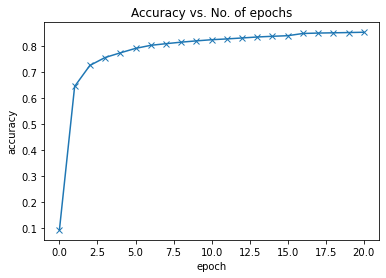

In [57]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

## Testing with Individual Images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by recreating the test dataset with the ToTensor transform.

In [62]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

In [63]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


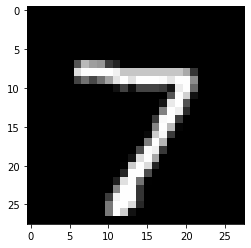

In [64]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))